# Training MixtureOfSVGPExperts on the Motorcycle Data Set (with three experts)

This notebook is a basic example of configuring and training a Mixture of Gaussian Process Experts (using `MixtureOfSVGPExperts`) in the gerenal case, i.e. with more than two experts. This notebook instantiates the model with three experts and trains it on the motorcycle dataset. It's worth noting that this approach is applicable for any number of experts. 

In [ ]:
import numpy as np
import gpflow as gpf
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import clear_output

from gpflow import default_float
from gpflow.inducing_variables import InducingPoints, SharedIndependentInducingVariables
from gpflow.likelihoods import Softmax
from gpflow.utilities import print_summary

from mogpe.experts import SVGPExperts, SVGPExpert
from mogpe.gating_networks import SVGPGatingNetwork
from mogpe.mixture_of_experts import MixtureOfSVGPExperts
from mogpe.training import training_tf_loop
from mogpe.helpers.plotter import Plotter1D

Let's start by loading the motorcycle dataset and plotting it to see what we're dealing with.

In [ ]:
def load_mcycle_dataset(filename='../data/mcycle.csv'):
    df = pd.read_csv(filename, sep=',')
    X = pd.to_numeric(df['times']).to_numpy().reshape(-1, 1)
    Y = pd.to_numeric(df['accel']).to_numpy().reshape(-1, 1)

    X = tf.convert_to_tensor(X, dtype=default_float())
    Y = tf.convert_to_tensor(Y, dtype=default_float())
    print("Input data shape: ", X.shape)
    print("Output data shape: ", Y.shape)

    # standardise input
    mean_x, var_x = tf.nn.moments(X, axes=[0])
    mean_y, var_y = tf.nn.moments(Y, axes=[0])
    X = (X - mean_x) / tf.sqrt(var_x)
    Y = (Y - mean_y) / tf.sqrt(var_y)
    data = (X, Y)
    return data

Input data shape:  (133, 1)
Output data shape:  (133, 1)


2021-12-08 18:49:51.670128: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


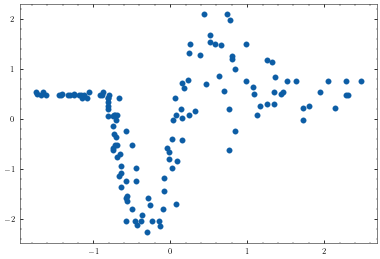

In [3]:
data_file = '../data/mcycle.csv'
dataset = load_mcycle_dataset(filename=data_file)
X, Y = dataset
num_data, input_dim = X.shape
output_dim = Y.shape[1]
plt.scatter(X, Y)

Given this data set, let's specify some of the model and training parameters. It is clear that there is a low noise, long lengthscales function at $x<-1$ and at $x>-1$ the noise increases and the lengthscale shortens. When fitting `MixtureOfSVGPExperts` with two experts the gating network starts tending to a uniform distribution at $x>1$. It is therefore interesting to consider if the model will fit a third expert in this region. With this knowledge, let's initialise expert one and expert three with long lengthscales and expert two with a shorter lengthscale. We specify each expert to have 4 inducing points and the gating network to have 7 inducing points.

In [4]:
num_experts = 3
experts_lengthscales = [10.0, 1.0, 10.0]  # lengthsales for expert 1 and 2
# experts_lengthscales = [1.0, 1.0, 1.0]  # lengthsales for expert 1 and 2
num_inducing_expert = 4  # number of inducing points for each expert
num_inducing_gating = 7  # number of inducing points for the gating network
num_samples = 1  # number of samples to draw from variational posterior in ELBO
batch_size = 16
learning_rate = 0.01

In order to initialie the `MixtureOfSVGPExperts` class for three experts we must pass it an instance of `SVGPExperts` and an instance of `SVGPGatingNetwork` with a `Softmax` likelihood. Let's start by creating an instance of `SVGPExperts`. To do this we must first create three SVGPExpert instances and pass them as a list to `SVGPExperts`.

In [5]:
def init_expert(lengthscales=1.0, kernel_variance=1.0, noise_variance=1.0):
    idx = np.random.choice(range(num_data), size=num_inducing_expert, replace=False) 
    inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)
    inducing_variable = gpf.inducing_variables.InducingPoints(inducing_variable)

    mean_function = gpf.mean_functions.Constant()
    likelihood = gpf.likelihoods.Gaussian(noise_variance)
    kernel = gpf.kernels.RBF(lengthscales=lengthscales, variance=kernel_variance)

    return SVGPExpert(kernel,
                      likelihood,
                      mean_function=mean_function,
                      inducing_variable=inducing_variable)

In [6]:
experts_list = [init_expert(lengthscales=experts_lengthscales[k]) for k in range(num_experts)]

We can now create an instance of `SVGPExperts` by instantiating three experts and passing them to `SVGPExperts` constructor as a list.

In [7]:
experts = SVGPExperts(experts_list)
print_summary(experts, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGPExperts.experts_list[0].mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.]
SVGPExperts.experts_list[0].kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGPExperts.experts_list[0].kernel.lengthscales,Parameter,Softplus,,True,(),float64,10.0
SVGPExperts.experts_list[0].likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGPExperts.experts_list[0].inducing_variable.Z,Parameter,Identity,,True,"(4, 1)",float64,[[1.34690746...
SVGPExperts.experts_list[0].q_mu,Parameter,Identity,,True,"(4, 1)",float64,[[0....
SVGPExperts.experts_list[0].q_sqrt,Parameter,FillTriangular,,True,"(1, 4, 4)",float64,"[[[1., 0., 0...."
SVGPExperts.experts_list[1].mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.]
SVGPExperts.experts_list[1].kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGPExperts.experts_list[1].kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0


We now need to create an instance of `SVGPGatingNetwork` with a `Softmax` likelihood. In contrast to the two expert case (where a single gating function can be used), the general case requires a gating function for each expert. The `SVGPGatingNetwork` inherits GPflow's multioutput `SVGP` and uses `SharedIndependentInducingVariables` for the inducing inputs and `SeparateIndependent` kernels. The gating functions are independent but should share the same inducing inputs, unlike the experts where the separate inducing points loosely partition the data set.

In [8]:
def init_gating_network(num_experts):
    idx = np.random.choice(range(num_data), size=num_inducing_gating, replace=False) 
    inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)
    inducing_variable = SharedIndependentInducingVariables(InducingPoints(inducing_variable))

    mean_function = gpf.mean_functions.Zero()
    kernel_list = [gpf.kernels.RBF() for _ in range(num_experts)]
    kernel = gpf.kernels.SeparateIndependent(kernel_list)

    return SVGPGatingNetwork(kernel,
                             likelihood=Softmax(num_experts),
                             inducing_variable=inducing_variable,
                             num_gating_functions=num_experts,
                             mean_function=mean_function)

In [9]:
gating_network = init_gating_network(num_experts=num_experts)
print_summary(gating_network, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGPGatingNetwork.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGPGatingNetwork.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGPGatingNetwork.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGPGatingNetwork.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGPGatingNetwork.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,1.0
SVGPGatingNetwork.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGPGatingNetwork.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(7, 1)",float64,[[1.72909446...
SVGPGatingNetwork.q_mu,Parameter,Identity,,True,"(7, 3)",float64,"[[0., 0., 0...."
SVGPGatingNetwork.q_sqrt,Parameter,FillTriangular,,True,"(3, 7, 7)",float64,"[[[1., 0., 0...."


We now have all the components to construct our `MixtureOfSVGPExperts` model so let's go ahead and do it.

In [10]:
model = MixtureOfSVGPExperts(gating_network=gating_network, 
                             experts=experts, 
                             num_samples=num_samples,
                             num_data=num_data)
print_summary(model, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
MixtureOfSVGPExperts.gating_network.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
MixtureOfSVGPExperts.gating_network.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
MixtureOfSVGPExperts.gating_network.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
MixtureOfSVGPExperts.gating_network.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
MixtureOfSVGPExperts.gating_network.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,1.0
MixtureOfSVGPExperts.gating_network.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1.0
MixtureOfSVGPExperts.gating_network.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(7, 1)",float64,[[1.72909446...
MixtureOfSVGPExperts.gating_network.q_mu,Parameter,Identity,,True,"(7, 3)",float64,"[[0., 0., 0...."
MixtureOfSVGPExperts.gating_network.q_sqrt,Parameter,FillTriangular,,True,"(3, 7, 7)",float64,"[[[1., 0., 0...."
MixtureOfSVGPExperts.experts.experts_list[0].mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.]


We can use the Plotter1D class from `mogpe.helpers.plotter` to plot our model before training.  
- The top plot shows mixing probablility for each expert,
- Middle plots show each experts latent GP,
- The bottom plot shows the models posterior with the mean (black line) and samples (green dots).

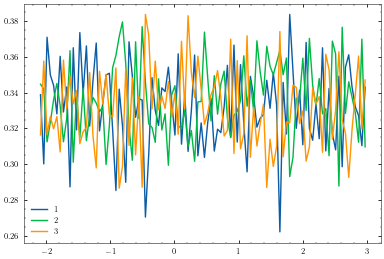

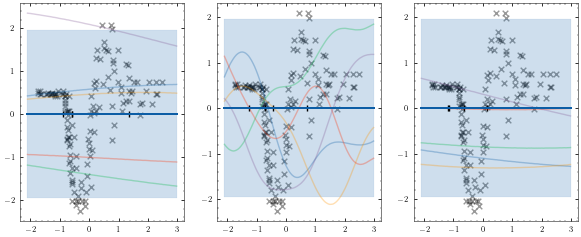

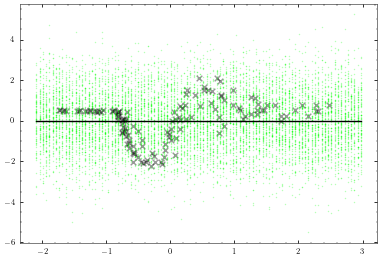

In [11]:
plotter = Plotter1D(model, X, Y)
plotter.plot_model()

We must now convert our numpy data set into a TensorFlow data set and set it up for stochastic optimisation by setting the batch size. We set drop_remainder=True to ensure the model receives the batch size.

In [12]:
prefetch_size = tf.data.experimental.AUTOTUNE
shuffle_buffer_size = num_data // 2
num_batches_per_epoch = num_data // batch_size
train_dataset = tf.data.Dataset.from_tensor_slices(dataset)
train_dataset = (train_dataset.repeat().prefetch(prefetch_size).shuffle(
    buffer_size=shuffle_buffer_size).batch(batch_size, drop_remainder=True))

We then use GPflows training_loss_closure method to get our training loss.

In [13]:
training_loss = model.training_loss_closure(iter(train_dataset))

In mogpe.training.training_loops some training loops are defined. Here we use the simple training_tf_loop which runs the Adam optimizer on model with training_loss as the objective function. The loop does not use any TensorBoard monitoring. We first configure the training/logging parameters.

In [14]:
logging_epoch_freq = 5
plotting_epoch_freq = 500
num_epochs = 2000

In [15]:
def plot_elbo(elbo):
    plt.subplot(111)
    plt.scatter(np.arange(len(elbo))*logging_epoch_freq, elbo)
    plt.xlabel("Epoch")
    plt.ylabel("ELBO")

Epoch 2000: ELBO (train) 49.81311591329514


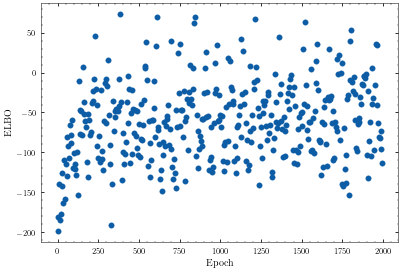

In [16]:
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def tf_optimization_step():
    optimizer.minimize(training_loss, model.trainable_variables)

elbo_log = []
for epoch in range(num_epochs):
    for _ in range(num_batches_per_epoch):
        tf_optimization_step()
    epoch_id = epoch + 1
    if epoch_id % logging_epoch_freq == 0:
        elbo_log.append(training_loss()*-1.0)
    if epoch_id % plotting_epoch_freq == 0:
        clear_output(True)
        tf.print(f"Epoch {epoch_id}: ELBO (train) {training_loss()}")
        plot_elbo(elbo_log)
        plt.show()

Now that we have trained the model we can use our plotter again to visualise what we have learned.

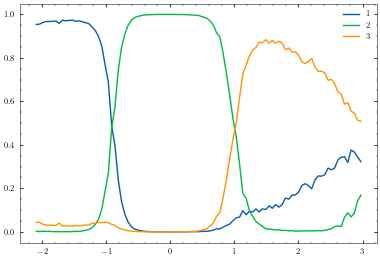

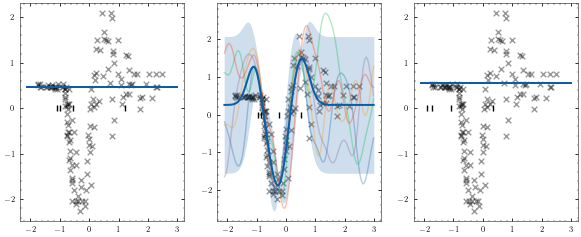

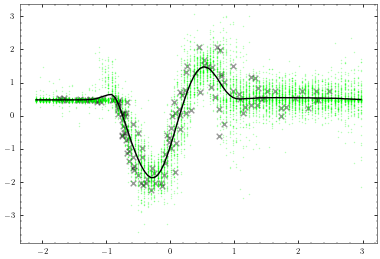

In [17]:
plotter.plot_model()

In [18]:
print_summary(model, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
MixtureOfSVGPExperts.gating_network.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,7.135789778871159
MixtureOfSVGPExperts.gating_network.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.3016590612834866
MixtureOfSVGPExperts.gating_network.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,23.512699977881155
MixtureOfSVGPExperts.gating_network.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.8741896699556088
MixtureOfSVGPExperts.gating_network.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.1437596400755563
MixtureOfSVGPExperts.gating_network.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,0.8437475112514834
MixtureOfSVGPExperts.gating_network.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(7, 1)",float64,[[1.26555844...
MixtureOfSVGPExperts.gating_network.q_mu,Parameter,Identity,,True,"(7, 3)",float64,"[[-0.89398975, -0.55701677, 0.18885994..."
MixtureOfSVGPExperts.gating_network.q_sqrt,Parameter,FillTriangular,,True,"(3, 7, 7)",float64,"[[[2.84199781e-01, 0.00000000e+00, 0.00000000e+00..."
MixtureOfSVGPExperts.experts.experts_list[0].mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.47284263]
